## Baseline search engine for EviDENce

Search strategy

1. Collect corpus to perform search on
2. Index documents in corpus
3. Collect Keywords
4. Construct query
5. Perform search
6. Analyze results

In [1]:
import numpy as np
import os
import pandas as pd
import string
import sys

**1. Collect corpus to perform search on**

Our corpus consists of oral history accounts.
These are broken up in text fragments of 100 lemmas and can be found in a zip folder on surfdrive:

../Data/NR-teksts/EviDENce_NR_output/TargetSize100/Lemma_preserve_paragraph.zip

*Make sure to extract the zip folder on high-level location on your computer a to avoid "path-too-long" error*


In [2]:
# Provide path to extracted folder with lemma fragments
root = os.path.join(os.sep,"media","sf_MartinedeVos")
search_dir = os.path.join(os.sep,root,"lem_par_150","lemma_preserve_paragraph")

In [3]:
# Path to alternative folder with lemma fragments
surf = os.path.join(os.sep,root,"surfdrive","Projects", "EviDENce","Data","NR-Teksts","EviDENce_NR_output")
alt_search_dir = os.path.join(os.sep,surf,"Size200","fragmented_lemmas")

**2. Index all documents (i.e., lemma fragments) in the directory**

* Create Schema
* Add documents
* Perform indexing

_NB: this step only has to be run once, or when data is added or changed_

In [4]:
from baseline_search import create_searchable_data

# The creation of an index is only needed once; after that, opending the existing index is sufficient
# in that case, the following line should be commented out

#create_searchable_data(search_dir)


**3. Collect list of keywords from CEO-ECB mappings**

Keywords are based on mappings from classes of the Circumstantial Event Ontology (CEO) on the ECB+ corpus

Preprocessing entails:
* express keywords as lemmas to ensure more effective matching 
* manually select keywords related to violence
* translate selected keywords to Dutch

In [ ]:
# The following functions use the google translate API 
# As this API has stability issues, there is a workaround in the next cell
from baseline_search import create_lemma_list
from baseline_search import eng_to_dutch_list

mention_file ="../data/MdV_selectedCEOECB.csv"

en_mentions = create_lemma_list(mention_file)
nl_mentions = eng_to_dutch_list(en_mentions)

In [6]:
import pandas as pd

prefab_file = "../data/nl_mentions.csv"
prefab_mentions = pd.read_csv(prefab_file,sep=';',encoding = "ISO-8859-1")
nl_mentions = list(prefab_mentions["Mention"])

**4. Construct query**

* Sort keywords
* Add double quotes to phrase queries
* Concatenate all keywords into one query string

In [7]:
from baseline_search import quote_phrases

nl_mention_list = list(set(nl_mentions))
quoted_nl_mention_list = quote_phrases (nl_mention_list)
nl_mention_query = ",".join(quoted_nl_mention_list)

**5. Perform search**

Using whoosh library:

* Define query parser: which schema, which search fields, AND/OR search
* Define searcher: which scoring approach
* Store info from results object in pandas dataframe

In [26]:
from collections import defaultdict
import pandas as pd
from whoosh import scoring
from whoosh import qparser
from whoosh.index import open_dir

indexdir = os.path.join(os.sep,search_dir,"indexdir")
ix = open_dir(indexdir)

parser = qparser.QueryParser("content", schema=ix.schema,group=qparser.OrGroup)
my_query = parser.parse(nl_mention_query)

cols_list = []
titles_list = []

with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
    results = searcher.search(my_query,limit=None, terms = True)
    for res in results:
        titles_list.append(res["title"])
        #row_dict = {}
        col_dict = defaultdict(int)
        hits = [term.decode('utf8')  for where,term in res.matched_terms()]
        for hit in hits:
            col_dict[hit]+= 1
            #row_dict[hit] = row_dict.get(hit, 0) + 1  
        cols_list.append(col_dict)

#Create a dataframe for results of this search, i.e. with a limited set of keywords 
results_df = pd.DataFrame(cols_list)
results_df.set_index([titles_list], inplace=True)

**6. Process and describe results** 

* Describe general characteristics of baseline search
    * Original corpus size
    * Number of keywords


In [30]:
all_docs = ix.searcher().documents() 
sum_docs = sum(1 for x in all_docs)

sum_results =len(results_df.index)
percent_hits = (sum_results/sum_docs)*100

sum_keywords = sum(1 for x in nl_mention_list)

In [33]:
report = 'Baseline results.txt'

with open(report, 'w') as file_handler:
    # Add path to corpus
    file_handler.write("Original corpus size: %s \n"%sum_docs)
    file_handler.write("Number of snippets with keyword(s) present: %s \n"%sum_results)
    file_handler.write("Percentage snippets with keywords(s) in corpus: %s \n"%percent_hits)
    # Add path to keywords
    file_handler.write("Total number of keywords found: %s \n"%sum_keywords)
    file_handler.write("Total number of unique keywords found: %s \n"%len(results_df.columns))

Search results dataframe contains:
* only those keywords that are found in documents
* only those documents that have one or more keywords

Combined dataframe contains: 
* all keywords, also those that are not present in documents
* all documents, also those that have no keywords
* total column for total nr of hits per fragment
* total row for total nr of hits per keyword

In [14]:
#Create a dataframe for all docs and keywords with empty values
keywords_dic = {term:0 for term in quoted_nl_mention_list}
list_docs = [doc['title'] for doc in ix.searcher().documents()] 

all_df = pd.DataFrame(keywords_dic, index = list_docs)

# Create a dataframe for all docs and keywords with search results
merged_df = results_df.combine_first(all_df)

In [ ]:
# Apparently phrase queries are still broken up in separate search terms
# this is shown by the surplus in columns in merged_df
surplus = [col for col in merged_df if col not in all_df]

# Remove these for now as a workaround; phrase queries should be fixed
merged_df = merged_df.drop(columns = surplus)
merged_df.describe()

In [36]:
merged_df['sum_docs'] = merged_df.sum(axis=1)
merged_df.loc['sum_keywords'] = merged_df.sum()

* Analyze results
    * nr keywords found per document
    * nr keywords found per category
    * nr hits found per keyword 
    * missed keywords


In [46]:
# Create new dataframe for keywords
keyword_df = pd.DataFrame(merged_df.loc['sum_keywords'].iloc[:-1])
keyword_df = keyword_df.sort_values(by=['sum_keywords'],ascending=False)

_NB: A pie chart with percentages is not informative, as we don't know how the frequencies are distributed over all keywords. Maybe first a barchart and use the cut-off for pie chart_

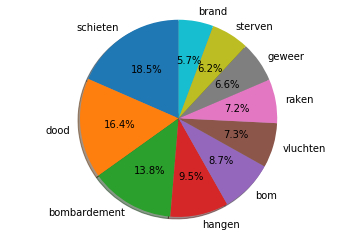

In [60]:
import matplotlib.pyplot as plt

# plot ten most frequent keywords
keywords = keyword_df.iloc[1:11].index.tolist()
freqs = keyword_df.iloc[1:11].values.tolist()
freqs

fig1, ax1 = plt.subplots()
ax1.pie(freqs, labels=keywords, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(root,"surfdrive","Projects", "EviDENce","Freq_keywords.png"))

**Todo:**
* Which keywords are not found?
* How is the distribution of violence over the corpus?

In [ ]:
missed_terms2 = df_sumkw.loc[df_sumkw['sum_keywords']==0].index.tolist()


In [ ]:
df2 = df.iloc[:,[0,-1]]
all_docs = {x['title']:0 for x in ix.searcher().documents()}

# Write in file: documents without keywords
no_hit_docs = [item for item in list(all_docs.keys()) if item not in titles_list] 

with open('no_hits_snippets.txt', 'w') as file_handler:
    for item in no_hit_docs:
        file_handler.write("{}\n".format(item))
        
#df3 = df2.set_index('title')
#df3
#df3 = pd.DataFrame.from_dict(all_docs, orient ='index',columns =['sum_docs'])
                             
#res = pd.concat([df2,df3],sort=False)       

#res
#df3.columns = ['sum_docs']

#print(df2.groupby(['sum_docs']).groups)
#df2.value_counts().plot(kind='bar')

#df2['sum_docs'].value_counts().plot(kind='bar')
#df2.groupby(['sum_docs'])['title'].value_counts().plot(kind='bar')
#df2.hist(column=['title'],by=['sum_docs'],bins=10,histtype='step')